In [2]:
import numpy as np
import pandas as pd
import sklearn
import operator
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.model_selection import KFold

from sklearn.cross_validation import train_test_split,cross_val_score, cross_val_predict
# from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
%inline matplotlib

UsageError: Line magic function `%inline` not found.


In [3]:
def chooseDataset(name):
    dataPath = 'datasets/'
    if name == 'diabetes':
        colNames= ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
        df = pd.read_csv(dataPath + 'PIMA_Indiana_diabetes/pima-indians-diabetes.data.csv', names = colNames)
        missCol = ['glucose','bp','skin','insulin','bmi']
        for col in missCol:
            df[col].replace([0,0.0], np.nan, inplace = True)
                   
#       convert 0 as missing values
    elif name == 'breastCancer':
        colNames = ['sampleCodeNumber', 'clumpThickness', 'uniformityCellSize', 'uniformityCellShape', 'marginalAdhesion', 'singleEpithelialCellSize', 'bareNuclei', 'blandChromatin', 'normalNucleoli', 'mitoses', 'label']
        df = pd.read_csv(dataPath + 'BreastCancer/breast-cancer-wisconsin.data.txt', names = colNames)
        df.replace("?", np.nan, inplace= True)
        df['bareNuclei'] = pd.to_numeric(df['bareNuclei'])
        # making class labels as 0 (Benign) and 1 (Malignant)
        df['label'] = df['label'].replace(2, 0)
        df['label'] = df['label'].replace(4, 1)
        missCol = ['bareNuclei']
#         print pd.unique(df[missCol].values.ravel('K'))
    elif name == 'parkinsons':
        colNames= ['name','MDVP:Fo','MDVP:Fhi','MDVP:Flo','MDVP:Jitter(%)','MDVP:Jitter(Abs)','MDVP:RAP','MDVP:PPQ','Jitter:DDP','MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','MDVP:APQ','Shimmer:DDA','NHR','HNR','Class','RPDE','DFA','spread1','spread2','D2','PPE']
        df=pd.read_csv(datapath+'Parkinsons/parkinsons.data.txt',names=colNames)
        missCol=[]
        #no missing values
        
    elif name == 'BUPA':
        #not given which one is infected
        colNames = ['mcv', 'alkphos', 'sgpt','sgot','gammagt','drinks','Class']
        df = pd.read_csv(datapath + 'BUPA(Liver)/bupa.data.txt',names = colNames )
        df.drop_duplicates(subset=None, keep='first', inplace=True)
        df['Class'] = df['Class'].replace(1, 0)
        df['Class'] = df['Class'].replace(2, 1)
        missCol=[]
        
    elif name == 'Cleveland':
        colNames= ['age','sex','cp','trestbps','chol','fbs','restecg'  ,'thalach', 'exang', 'oldpeak','slope','ca', 'thal','Class']
        df = pd.read_csv(datapath + 'Cleveland(Heart)/processed.cleveland.data.txt',names = colNames)
        df.replace ("-9.0",np.nan,inplace=True)
        missCol = df.columns[df.isna().any()].tolist()
        
    elif name == 'Hepatitis':
        colNames =['Class','AGE','SEX','STEROID','ANTIVIRALS','FATIGUE','MALAISE','ANOREXIA','LIVER BIG','LIVER FIRM','SPLEEN PALPABLE','SPIDERS','ASCITES','VARICES','BILIRUBIN','ALK PHOSPHATE','SGOT','ALBUMIN','PROTIME','HISTOLOGY']
        df = pd.read_csv(datapath + 'Hepatitis/hepatitis.data.txt',names= colNames)
        df.replace("?",np.nan,inplace=True)
        missCol= df.columns[df.isna().any()].tolist()
        
    elif name == 'ILPD':
        colNames =['Age','Gender','TB','DB','Alkphos','SGPT','SGOT','TP','ALB','A/G','Class']
        df = pd.read_csv(datapath + 'ILPD(Liver)/ILPD.csv',names= colNames)
        missCol=[]
        
    else:
        print ("NOT FOUND")
        return
    return df, missCol
        

In [4]:
df, missCol = chooseDataset('breastCancer')
print (df.columns, df.dtypes, df.shape)
print (df.head())

Index(['sampleCodeNumber', 'clumpThickness', 'uniformityCellSize',
       'uniformityCellShape', 'marginalAdhesion', 'singleEpithelialCellSize',
       'bareNuclei', 'blandChromatin', 'normalNucleoli', 'mitoses', 'label'],
      dtype='object') sampleCodeNumber              int64
clumpThickness                int64
uniformityCellSize            int64
uniformityCellShape           int64
marginalAdhesion              int64
singleEpithelialCellSize      int64
bareNuclei                  float64
blandChromatin                int64
normalNucleoli                int64
mitoses                       int64
label                         int64
dtype: object (699, 11)
   sampleCodeNumber  clumpThickness  uniformityCellSize  uniformityCellShape  \
0           1000025               5                   1                    1   
1           1002945               5                   4                    4   
2           1015425               3                   1                    1   
3           101

In [5]:
# normalizing data
def normalizeData(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i in df.columns:
        null_index = df[i].isnull()
        df.loc[~null_index, [i]] = scaler.fit_transform(df.loc[~null_index, [i]])
    return df

In [6]:
df = normalizeData(df)
print (df.head())

# print pd.unique(df[missCol].values.ravel('K'))

   sampleCodeNumber  clumpThickness  uniformityCellSize  uniformityCellShape  \
0          0.070067        0.444444            0.000000             0.000000   
1          0.070285        0.444444            0.333333             0.333333   
2          0.071217        0.222222            0.000000             0.000000   
3          0.071281        0.555556            0.777778             0.777778   
4          0.071336        0.333333            0.000000             0.000000   

   marginalAdhesion  singleEpithelialCellSize  bareNuclei  blandChromatin  \
0          0.000000                  0.111111    0.000000        0.222222   
1          0.444444                  0.666667    1.000000        0.222222   
2          0.000000                  0.111111    0.111111        0.222222   
3          0.000000                  0.222222    0.333333        0.222222   
4          0.222222                  0.111111    0.000000        0.222222   

   normalNucleoli  mitoses  label  
0        0.000000   

In [7]:
def computeMissing(df,missCol, k = 5):
    # get No Missing Data Rows 
#     print pd.unique(df[missCol].values.ravel('K'))
    no_missing_df = df.dropna(axis=0, how='any')
#     print(no_missing_df.shape, df.shape)
#     print no_missing_df.head()
    # get Missing Data Rows 
    missing_df = pd.DataFrame(df[~df.isin(no_missing_df).all(1)])
#     print missing_df.head()
    # removed last column
    data = no_missing_df.drop(['label'], axis = 1, inplace = False)
    # Create the knn model.
    y_columns = missCol
    x_columns = data.columns.tolist()
#     print y_columns
    for col in y_columns:
        x_columns.remove(col)
        
    # Look at the five closest neighbors.
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit the model on the training data.
    knn.fit(no_missing_df[x_columns], no_missing_df[y_columns])
    # Make point predictions on the test set using the fit model.
    predictions = knn.predict(missing_df[x_columns])
    missing_df[y_columns] = predictions
    no_missing_df = no_missing_df.append(missing_df)
    return no_missing_df

In [8]:
df = computeMissing(df, missCol)

In [9]:
df.shape
df.head()

,sampleCodeNumber,clumpThickness,uniformityCellSize,uniformityCellShape,marginalAdhesion,singleEpithelialCellSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
0,0.070067,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,0.0
1,0.070285,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0,0.0
2,0.071217,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0,0.0
3,0.071281,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0,0.0
4,0.071336,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0,0.0


In [10]:
def removeOutliers(df):
    maskall = {}
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    for col in df.columns[:-1]:
        IQR = Q3[col] - Q1[col]
        mask = df[col].between(Q1[col] - 1.5*IQR, Q3[col] + 1.5*IQR, inclusive=True)
        maskall[col] =mask
        df = df[mask]
#         print df.shape
    return df

In [11]:
df2 = removeOutliers(df)
print (df2.shape)

(491, 11)


In [12]:
label = df['label']
df.drop('label', axis=1, inplace=True)

In [13]:
X, y = df, label
print (X,y)

     sampleCodeNumber  clumpThickness  uniformityCellSize  \
0            0.070067        0.444444            0.000000   
1            0.070285        0.444444            0.333333   
2            0.071217        0.222222            0.000000   
3            0.071281        0.555556            0.777778   
4            0.071336        0.333333            0.000000   
5            0.071344        0.777778            1.000000   
6            0.071417        0.000000            0.000000   
7            0.071451        0.111111            0.000000   
8            0.072535        0.111111            0.000000   
9            0.072535        0.333333            0.111111   
10           0.072700        0.000000            0.000000   
11           0.072766        0.111111            0.000000   
12           0.073187        0.444444            0.222222   
13           0.073351        0.000000            0.000000   
14           0.073393        0.777778            0.666667   
15           0.073622   

In [15]:
print (X.shape)

(699, 10)


In [16]:
def PCA_Compute(X,y, n = 0):
    pca = PCA(n_components= X.shape[-1] - n, svd_solver='full')
    pca.fit(X,y)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)
    return X,y

In [17]:
def Fscore_Compute(X,y, n = 5):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(X,y)
    X = selector.transform(X)
    print (selector.scores_, X.shape)
    return X,y

In [18]:
X,y = Fscore_Compute(X,y)

[   4.51505927  733.20697841 1408.52721279 1419.30553012  657.79369959
  608.71955539 1417.3134106   933.28729668  717.62804135  152.04023895] (699, 5)


In [19]:
X,y = PCA_Compute(X,y)

[0.76363341 0.09446862 0.08061308 0.04300141 0.01828348]


In [20]:
print (X.shape)

(699, 5)


In [21]:
def getQDA(X,y):
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
    clf = QDA()
    QDA(priors=None, reg_param=0.0,store_covariances=True, tol=0.0001)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [23]:
print  (getQDA(X,y))

0.9557843330199063


In [27]:
def getLR(X,y):
    from sklearn import datasets, linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=k_fold)
    regr.predict(X_test)
    return scores.mean()


In [28]:
# help(KFold)
print (getLR(X,y))

TypeError: 'KFold' object is not iterable

In [29]:
def getSVM(X,y):
    from sklearn import svm
    svc = svm.SVC(C=1, kernel='linear')
    scores = cross_val_score(svc, X, y, cv=5, scoring='precision_macro')
    return scores.mean()

In [30]:
print (getSVM(X,y))

0.960518075631678


In [31]:
def getKNN(X,y,k):
    knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'ball_tree', leaf_size=500)
    scores = cross_val_score(knn, X, y, cv=5, scoring='precision_macro')
    return scores.mean()

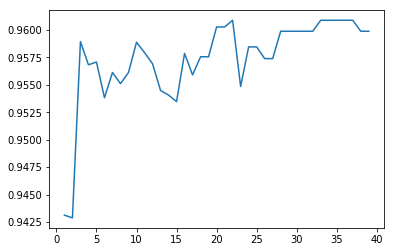

In [37]:
kr = range(1,40)
ac = []
for k in kr:
    ac.append(getKNN(X,y,k))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(kr,ac)
plt.show()

In [33]:
getKNN(X,y,7)

0.9561124005048651

In [34]:
def getNaivebayes(X,y):
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    clf.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [35]:
print (getNaivebayes(X,y))

0.9543352066067511


In [36]:
def getDecisionTreeinfogain(X,y):
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier
    #X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', 
           random_state=100, splitter='best')
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [38]:
print(getDecisionTreeinfogain(X,y))

0.9457332371185119


In [39]:
def getDecisionTreegini(X,y):
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier
    #X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    clf = DecisionTreeClassifier(class_weight=None, criterion='gini', 
           random_state=100, splitter='best')
    scores = cross_val_score(clf, X, y, cv=5)
    #y_pred = clf.predict(X_test)
    return scores.mean()

In [40]:
print (getDecisionTreegini(X,y))

0.9471618085470833


In [47]:
def getEnsembleMajorityVoting(X,y):
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    clf1 = LogisticRegression(random_state=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft') 
    #weights=[2,1,1]
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [48]:
print (getEnsembleMajorityVoting(X,y))

0.9628661083291423


/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

In [53]:
def getEnsembleMajorityWeightedVoting(X,y, weights):
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    clf1 = LogisticRegression(random_state=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=weights) 
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [54]:
weights = [2,1,1]
print(getEnsembleMajorityWeightedVoting(X,y, weights))

0.965733528678577


/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/dinesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

In [1]:
def getRandomForest(X,y, numtrees =10):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=10)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [2]:
print (getRandomForest(X,y))

NameError: name 'X' is not defined

In [3]:
def getAdaBoost(X,y, estimators=100):
    from sklearn.ensemble import AdaBoostClassifier
    clf = AdaBoostClassifier(n_estimators=estimators)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores.mean()

In [4]:
from sklearn.neighbors import KNeighborsClassifier
def getBaggingClassifier(X,y, poorclf=KNeighborsClassifier()):
    from sklearn.ensemble import BaggingClassifier
    bagging = BaggingClassifier(poorclf,max_samples=0.5, max_features=0.5)
    scores = cross_val_score(bagging, X, y, cv=5)
    return scores.mean()